In [37]:
%run LoserAnalysis.ipynb

# Plot x for fixed y & z

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
TIME_LIM = 60  # seconds

In [40]:
y = z = 20  # dummy value for declaring the variables
FIG_NAME = f'Hitting probs for different x (y = {y}, z = {z}).png'

In [41]:
def varyX(minX, maxX, y, z, timeLimit=60):
    xs = range(minX, maxX+1)
    probs = {}
    
    for x in xs:
        state = (x,y,z)
        # Set up signal handler for SIGALRM, saving previous value
        oldHandler = signal.signal(signal.SIGALRM, sigalarmHandler)
        # Start timer
        signal.alarm(TIME_LIM)
        try:
            probs[x] = LoserAnalysis(state).getHittingProb()
        except TimeoutException:
            print(f'Took too long to find the hitting prob for state {state}')
        except RecursionError:
            print(f'maximum recursion depth exceeded for state {state}')
        finally:
            # Turn off timer
            signal.alarm(0)
            # Restore handler to previous value
            signal.signal(signal.SIGALRM, oldHandler)
        
    # use numerical approximation for the unrecorded states
    missedStates = [(x,y,z) for x in xs if x not in probs]
    numericalProbs = {s[0]:LoserAnalysis(s).getHittingProbNumerical() for s in missedStates}
    
    return probs, numericalProbs

In [42]:
# Automate the process
def plotXforFixedYZ(minX, maxX, y, z, probFunction=varyX, figName=FIG_NAME, t=30):
    """
    Plots x values within the range [`minX`, `maxX`] (inclusive) for fixed y and z.
    The `timeLimit` (in seconds) casts a limit on the computation time of the hitting prob for each state.
    Saves the plot to a file provided by the string `figName`.
    """
    exactProbs, numericalProbs = probFunction(minX, maxX, y, z, t)
    
    # plot
    plt.scatter([x for x in exactProbs.keys()], exactProbs.values(), 
            color='b', label='exact probs', s=2)
    plt.scatter([x for x in numericalProbs.keys()], numericalProbs.values(), 
                color='r', label='numerical probs', s=2)

    # add graph features
    plt.xlabel('x')
    plt.ylabel('P(loser = Player 1)')
    plt.title(f"Hitting probabilities for different x values (y = {y}, z = {z})")
    plt.legend()

    plt.savefig(FIG_NAME)
    plt.show()

maximum recursion depth exceeded for state (1, 100, 200)
maximum recursion depth exceeded for state (2, 100, 200)
maximum recursion depth exceeded for state (3, 100, 200)
Took too long to find the hitting prob for state (4, 100, 200)
Took too long to find the hitting prob for state (5, 100, 200)
maximum recursion depth exceeded for state (6, 100, 200)
maximum recursion depth exceeded for state (7, 100, 200)
Took too long to find the hitting prob for state (8, 100, 200)
maximum recursion depth exceeded for state (9, 100, 200)
maximum recursion depth exceeded for state (11, 100, 200)
Took too long to find the hitting prob for state (12, 100, 200)
maximum recursion depth exceeded for state (13, 100, 200)
maximum recursion depth exceeded for state (14, 100, 200)
Took too long to find the hitting prob for state (15, 100, 200)
Took too long to find the hitting prob for state (16, 100, 200)
maximum recursion depth exceeded for state (17, 100, 200)
maximum recursion depth exceeded for state (1

maximum recursion depth exceeded for state (154, 100, 200)
Took too long to find the hitting prob for state (155, 100, 200)
Took too long to find the hitting prob for state (156, 100, 200)
maximum recursion depth exceeded for state (157, 100, 200)
maximum recursion depth exceeded for state (158, 100, 200)
maximum recursion depth exceeded for state (159, 100, 200)
maximum recursion depth exceeded for state (161, 100, 200)
Took too long to find the hitting prob for state (162, 100, 200)
maximum recursion depth exceeded for state (163, 100, 200)
maximum recursion depth exceeded for state (164, 100, 200)
Took too long to find the hitting prob for state (165, 100, 200)
maximum recursion depth exceeded for state (166, 100, 200)
maximum recursion depth exceeded for state (167, 100, 200)
Took too long to find the hitting prob for state (168, 100, 200)
maximum recursion depth exceeded for state (169, 100, 200)
maximum recursion depth exceeded for state (171, 100, 200)
maximum recursion depth ex

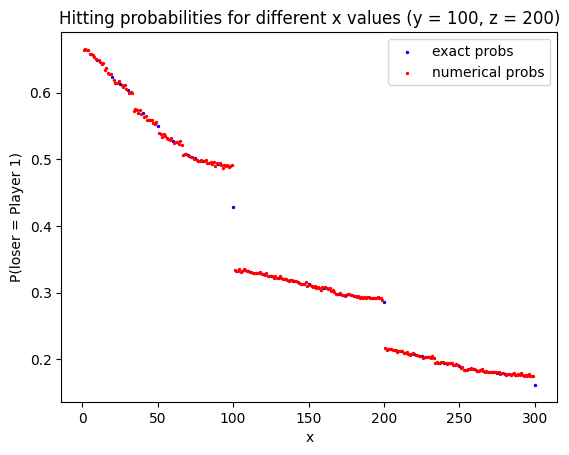

In [38]:
plotXforFixedYZ(1, 300, 100, 200, t=30)

In [32]:
class TimeoutException(Exception):
    """
    Custom exception for timeout.
    """
    pass

def sigalarmHandler(signum, frame):
    """
    Handler function to be called when SIGALRM is received.
    """
    # We get signal!
    raise TimeoutException()

In [ ]:
plotXforFixedYZ(1, 100, 20, 20, t=30)

Took too long to find the hitting prob for state (9, 20, 20)
Took too long to find the hitting prob for state (11, 20, 20)
Took too long to find the hitting prob for state (13, 20, 20)


## Adapted code using memoization

Adapt fixed sum code to vary x for fixed y & z.

In [7]:
import numpy as np

In [8]:
def memoize(f):
    """ Memoization decorator for functions taking one or more arguments. """
    class memodict(dict):
        def __init__(self, f):
            self.f = f

        def __call__(self, *args):
            return self[args]

        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret

    return memodict(f)

def out2(u,v):
    m=min(u,v)
    yield (u+m,v-m)
    yield (u-m,v+m)

def out3(x,y,z):
    for (X,Y) in out2(x,y): yield(X,Y,z)
    for (X,Z) in out2(x,z): yield(X,y,Z)
    for (Y,Z) in out2(y,z): yield(x,Y,Z)

 
@memoize
def Q(x,y,z,t=0):
    if x==0: return 1
    if z*y==0: return 0
    if z<y: return Q(x,z,y,t)  # put smaller stack size at front
    if t==0: return 0
    return sum(Q(X,Y,Z,t-1) for (X,Y,Z) in out3(x,y,z))/6

def precomp(N,t):
    for x in range(N+1):
        for y in range(N+1-x):
            return Q(x,y,N-x-y,t)

In [19]:
precomp(2000,10)

1

In [ ]:
# Example
# N=2000

# with open("poker_two_play_simplex_2000.txt","a") as ff:
#     for x in range(N+1):
#         for y in range(N+1-x):
#             ff.write(str(x)+" "+str(y)+" "+str(N-x-y)+" "+str(Q(x,y,N-x-y,10))+"\n")

In [9]:
def varyX_memoized(minX, maxX, y, z, t=10):
    return {}, {x:Q(x,y,z,t) for x in range(minX, maxX)} # no exact probs - just to comply with the return values of varyX

In [10]:
varyX_memoized(1, 20, 20, 20)

({},
 {1: 0.5292680655049197,
  2: 0.521353326527545,
  3: 0.5092737466976579,
  4: 0.5004434876119833,
  5: 0.49122878218725124,
  6: 0.47808047262654746,
  7: 0.4498510373799726,
  8: 0.4425199304814645,
  9: 0.43678178027993697,
  10: 0.4285657819670951,
  11: 0.4043071286664465,
  12: 0.39910167297498683,
  13: 0.39254663632110615,
  14: 0.3769258700930583,
  15: 0.3725328686239395,
  16: 0.3678566675028366,
  17: 0.36322505329260446,
  18: 0.3591694636022625,
  19: 0.3567542951616454})

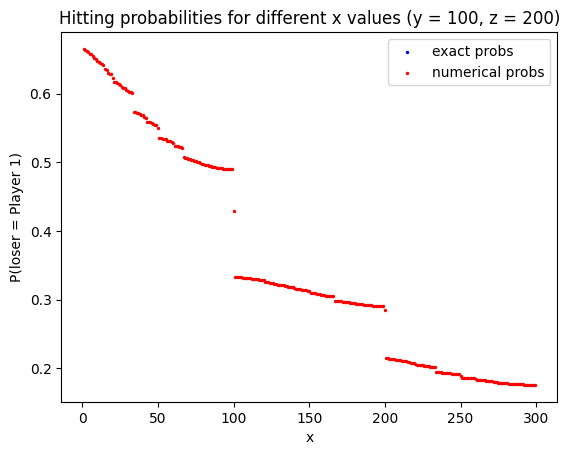

In [11]:
plotXforFixedYZ(1, 300, 100, 200, probFunction=varyX_memoized, t=10)

# Game 2

In [12]:
%run Game2.ipynb

In [13]:
def memoize(f):
    """ Memoization decorator for functions taking one or more arguments. """
    class memodict(dict):
        def __init__(self, f):
            self.f = f

        def __call__(self, *args):
            return self[args]

        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret

    return memodict(f)


@memoize
def Q(x,y,z,t=0):
    if x==0:
        return 1 if z*y>0 else 1/2
    if z*y==0: return 0
    if t==0: return 1/3
    m = min(x,y,z)
    return (np.longdouble(np.longdouble(Q(x+2*m,y-m,z-m,t-1)) + np.longdouble(Q(x-m,y+2*m,z-m,t-1))+ np.longdouble(Q(x-m,y-m,z+2*m,t-1))))/3


def precomp(N,t):
    for x in range(N+1):
        for y in range(N+1-x):
            Q(x,y,N-x-y,t)

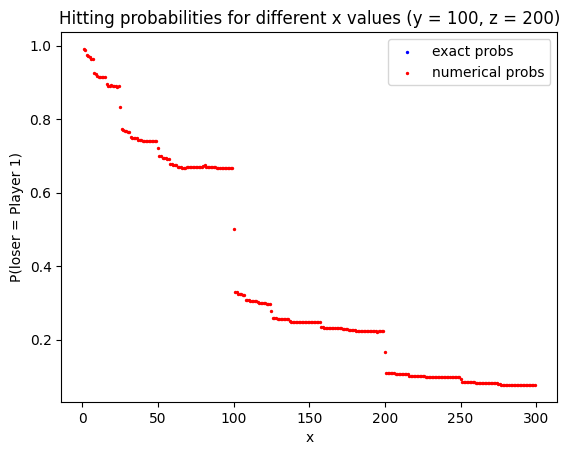

In [14]:
plotXforFixedYZ(1, 300, 100, 200, probFunction=varyX_memoized, t=10)